In [1]:
from NO_utils import extract_data, plot_geometry, plot_eigenvectors
import os
import matplotlib.pyplot as plt
import numpy as np
import random

## Load and visualize data

In [2]:
# Load and extract data
datafolder_name = ["OUTPUT", "discrete_symmetric_p32_n400_rs0"]
data_path = os.path.join(*datafolder_name)
print(data_path)

designs, design_params, n_designs, n_panes, design_res, WAVEVECTOR_DATA, n_dim, n_wavevectors, EIGENVALUE_DATA, n_bands, EIGENVECTOR_DATA_x, EIGENVECTOR_DATA_y, const, N_struct, imag_tol, rng_seed_offset = extract_data(data_path)

OUTPUT\discrete_symmetric_p32_n400_rs0
Data loaded in 356.99 seconds.
n_designs: 400, n_panes: 3, design_res: 32, d_design: 2, dispersion_bands: 6, rng_seed_offset: [[0.]]
EIGENVALUE_DATA shape: (400, 325, 6)
EIGENVECTOR_DATA shape: (400, 325, 6, 2048)
EIGENVECTOR_DATA_x shape: (400, 325, 6, 32, 32)
EIGENVECTOR_DATA_y shape: (400, 325, 6, 32, 32)
WAVEVECTOR_DATA shape: (400, 325, 2)
designs shape: (400, 3, 32, 32)
design_params shape: (1, 6)
const shape: {'E_max': (1, 1), 'E_min': (1, 1), 'N_eig': (1, 1), 'N_ele': (1, 1), 'N_pix': (1, 1), 'N_wv': (2, 1), 'a': (1, 1), 'design': (3, 32, 32), 'design_scale': (6, 1), 'isSaveEigenvectors': (1, 1), 'isUseGPU': (1, 1), 'isUseImprovement': (1, 1), 'isUseParallel': (1, 1), 'isUseSecondImprovement': (1, 1), 'poisson_max': (1, 1), 'poisson_min': (1, 1), 'rho_max': (1, 1), 'rho_min': (1, 1), 'sigma_eig': (1, 1), 'symmetry_type': (4, 1), 't': (1, 1), 'wavevectors': (2, 325)}


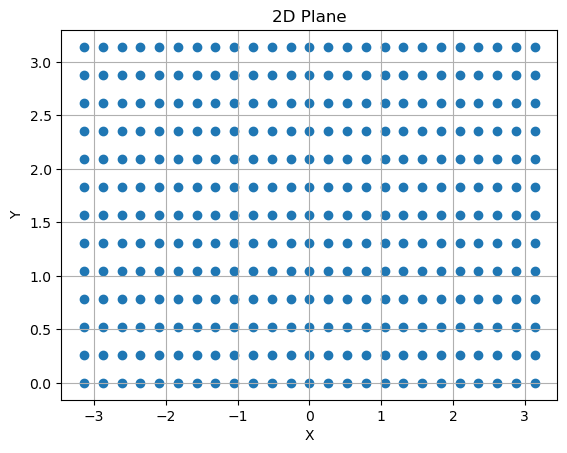

In [3]:
# View distribution of wavevectors in 2D plane
fig, ax = plt.subplots()
ax.scatter(WAVEVECTOR_DATA[0,:,0], WAVEVECTOR_DATA[0,:,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('2D Plane')
ax.grid(True)
plt.show()

In [4]:
# Draw a random design and its corresponding eigenvectors
random_seed = 100
random.seed(random_seed)
sample_index = np.random.randint(0, n_designs)
sample_geometry = designs[sample_index, 0]
sample_band = np.random.randint(0, n_bands)
sample_wavevector = np.random.randint(0, n_wavevectors)
print(f'Design: {sample_index}, Band: {sample_band}, Wavevector: {sample_wavevector}')

Design: 69, Band: 3, Wavevector: 30


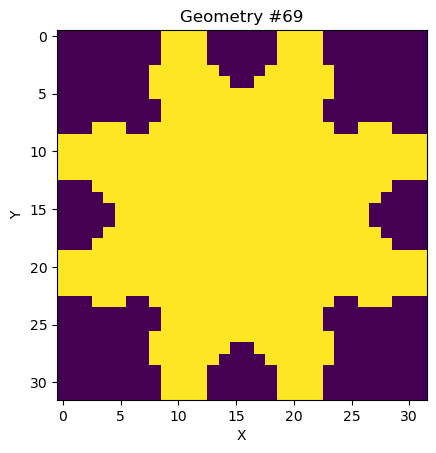

Wavevector index: 30, components: [-2.617  1.047]


In [5]:
# View a geometry design
plot_geometry(sample_geometry, sample_index)
print(f'Wavevector index: {sample_wavevector}, components: {WAVEVECTOR_DATA[sample_index,sample_wavevector]}')

Design: 69, Band: 3, Wavevector: 30


A:\Research\Projects\NO 2D Metamaterials\NO_utils.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


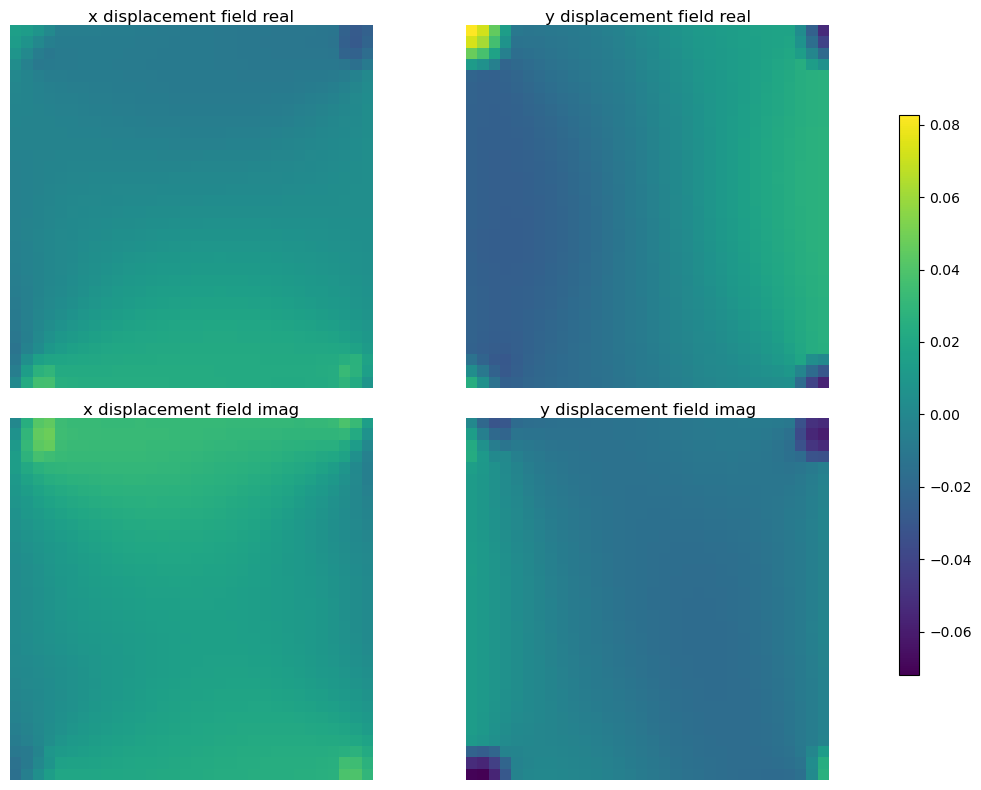

In [6]:
# View eigenvectors for the selected design, band, and wavevector
print(f'Design: {sample_index}, Band: {sample_band}, Wavevector: {sample_wavevector}')
sample_eigenvector_x = EIGENVECTOR_DATA_x[sample_index, sample_wavevector, sample_band]
sample_eigenvector_y = EIGENVECTOR_DATA_y[sample_index, sample_wavevector, sample_band]

plot_eigenvectors(sample_eigenvector_x, sample_eigenvector_y, unify_scales=True)

## Define model architecture

In [7]:
# Import modules for building a neural operator model
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# Import specialized neural operator model tools
from neuralop.models import FNO, TFNO, FNO2d, TFNO2d
from neuralop import Trainer
from neuralop.training import CheckpointCallback
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.datasets import data_transforms
from neuralop import LpLoss, H1Loss

# For creating datasets and data loaders for training and evaluation
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

# Optional: torchvision for augmentations and transformations (if working with image-like data)
import torchvision.transforms as transforms

# For plotting and visualization
import matplotlib.pyplot as plt

# Optional: Use tqdm for progress bars during training and evaluation
from tqdm import tqdm

# For handling file paths and directories
import os
import sys
import h5py

# Optional: If your model or data processing requires specific numerical operations (e.g., FFT)
from torch.fft import fft, ifft

# Optional: If you are working with graph data or architectures
# import torch_geometric

# If you need automatic differentiation for custom operations or gradients
from torch.autograd import Function

In [8]:
#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)

Using Device: cuda
Using PyTorch version: 2.1.0


In [9]:
# Prepare input data
num_samples = n_designs * n_wavevectors * n_bands
input_data = torch.zeros((num_samples, 4, design_res, design_res))

for i in range(n_designs):
    for j in range(n_wavevectors):
        for k in range(n_bands):
            sample_idx = i * n_wavevectors * n_bands + j * n_bands + k
            input_data[sample_idx, 0] = torch.from_numpy(designs[i, 0])
            input_data[sample_idx, 1] = torch.tensor(WAVEVECTOR_DATA[0, j, 0], dtype=torch.float32)
            input_data[sample_idx, 2] = torch.tensor(WAVEVECTOR_DATA[0, j, 1], dtype=torch.float32)
            input_data[sample_idx, 3] = k + 1

# Prepare output data
output_data = torch.zeros((num_samples, 4, design_res, design_res))

for i in range(n_designs):
    for j in range(n_wavevectors):
        for k in range(n_bands):
            sample_idx = i * n_wavevectors * n_bands + j * n_bands + k
            output_data[sample_idx, 0] = torch.from_numpy(EIGENVECTOR_DATA_x[i, j, k].real)
            output_data[sample_idx, 1] = torch.from_numpy(EIGENVECTOR_DATA_x[i, j, k].imag)
            output_data[sample_idx, 2] = torch.from_numpy(EIGENVECTOR_DATA_y[i, j, k].real)
            output_data[sample_idx, 3] = torch.from_numpy(EIGENVECTOR_DATA_y[i, j, k].imag)

# Create dataset
dataset = TensorDataset(input_data, output_data)

# Split dataset into train, test, and validation sets
train_size = int(0.75 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size

In [10]:
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

# Create data loaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [11]:
# Print the shapes of the input and output data, train, test, and validation sets
print('Input data shape:', input_data.shape)
print('Output data shape:', output_data.shape)
print('Train data size:', len(train_dataset))
print('Test data size:', len(test_dataset))
print('Validation data size:', len(val_dataset))

# Inspect the first batch of data
for sample in train_loader:
    print('Batch shape:', sample[0].shape, sample[1].shape)
    #print(sample)
    break

Input data shape: torch.Size([780000, 4, 32, 32])
Output data shape: torch.Size([780000, 4, 32, 32])
Train data size: 585000
Test data size: 156000
Validation data size: 39000
Batch shape: torch.Size([512, 4, 32, 32]) torch.Size([512, 4, 32, 32])


In [12]:
class FourierNeuralOperator(nn.Module):
    def __init__(self, modes_height, modes_width, in_channels=4, out_channels=4, hidden=128):
        super(FourierNeuralOperator, self).__init__()
        self.modes_height = modes_height  # Number of Fourier modes in height dimension
        self.modes_width = modes_width  # Number of Fourier modes in width dimension
        self.hidden = hidden  # Width of the hidden channels
        self.in_channels = in_channels  # Number of input channels
        self.out_channels = out_channels  # Number of output channels

        # FNO2d layer
        self.fno = FNO2d(in_channels=self.in_channels, out_channels=self.out_channels,
                         n_modes_height=self.modes_height, n_modes_width=self.modes_width,
                         hidden_channels=self.hidden, num_layers=4)

    def forward(self, x):
        # Apply the FNO2d layer
        x = self.fno(x)
        return x

In [13]:
# Example input
inputs = torch.randn(32, 4, 32, 32)  # Batch size of 32, 4 channels, 32x32 spatial dimensions

# Define the model
model = FourierNeuralOperator(modes_height=16, modes_width=16)

# Forward pass with example input
outputs = model(inputs)
print(outputs.shape)  # Should match the input shape [32, 4, 32, 32]

torch.Size([32, 4, 32, 32])


Operating Principle of FNOs:
Fourier Neural Operators (FNOs) are a class of neural network architectures designed to learn the mapping between function spaces. They leverage the properties of the Fourier transform to efficiently learn and represent complex spatial-temporal relationships in data.
The key idea behind FNOs is to perform convolutions in the Fourier space rather than the spatial domain. By transforming the input data into the Fourier space using the Fourier transform, FNOs can capture global dependencies and long-range interactions more effectively compared to traditional convolutional neural networks (CNNs).
In the Fourier space, the convolution operation becomes a pointwise multiplication, which is computationally efficient. FNOs learn a set of Fourier coefficients that represent the learned operator in the Fourier space. These coefficients are then used to transform the input function and obtain the output function.
The architecture of an FNO typically consists of three main components:

Lifting layer: This layer maps the input channels to a higher-dimensional space (hidden channels) to increase the expressiveness of the network.
Fourier neural operator (FNO) layer: This layer performs the convolutions in the Fourier space. It applies the Fourier transform to the input, performs pointwise multiplications with the learned Fourier coefficients, and then applies the inverse Fourier transform to obtain the output.
Projection layer: This layer maps the hidden channels back to the desired output channels.

Modifying the Architecture for Performance:
There are several ways to modify the FNO architecture to potentially improve performance:

Increase the number of Fourier modes: Increasing the number of Fourier modes allows the FNO to capture finer details and higher-frequency components in the data. However, this also increases the computational complexity and memory requirements.
Adjust the width of the fully connected layers: Increasing the width of the lifting and projection layers can enhance the expressiveness of the network. However, this also increases the number of parameters and computational cost.
Increase the number of FNO layers: Adding more FNO layers can allow the network to learn more complex relationships and capture deeper hierarchical features. However, this also increases the depth of the network and may lead to vanishing or exploding gradients.
Experiment with different activation functions: The choice of activation functions can impact the learning dynamics and convergence of the network. Commonly used activation functions include ReLU, LeakyReLU, and ELU.
Incorporate skip connections: Skip connections, such as residual connections, can help alleviate the vanishing gradient problem and facilitate the flow of information across layers. They can be added between the lifting layer and the projection layer or within the FNO layers.
Apply regularization techniques: Regularization techniques, such as L1/L2 regularization or dropout, can help prevent overfitting and improve generalization performance.

In [14]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, report_freq=100):
    model.train()
    running_loss = 0.0
    total_batches = len(loader)
    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
        loss.backward()

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Print progress for each batch
        if (batch_idx + 1) % report_freq == 0 or (batch_idx + 1) == total_batches:
            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{total_batches}, Batch Loss: {loss.item()}")

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Function to save the model weights
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)

# Function to load the model weights
def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))

In [15]:
model = FourierNeuralOperator(modes_height=16, modes_width=16, in_channels=4, out_channels=4, hidden=64).to(device)

# Define the loss function
criterion = nn.MSELoss()  # Using MSELoss for stability
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [16]:
# Single batch data check
inputs, targets = next(iter(train_loader))
inputs, targets = inputs.to(device), targets.to(device)
print(f"Input range: min={inputs.min().item()}, max={inputs.max().item()}")
print(f"Target range: min={targets.min().item()}, max={targets.max().item()}")

outputs = model(inputs)
print(f"Output range: min={outputs.min().item()}, max={outputs.max().item()}")

loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
if torch.isnan(loss).any() or torch.isinf(loss).any():
    print("Loss is NaN or Inf.")

    # Check if any values in outputs or targets are NaN or Inf
    if torch.isnan(outputs).any() or torch.isinf(outputs).any():
        print("Problematic Output Values:")
        print(outputs[torch.isnan(outputs) | torch.isinf(outputs)])  # Print problematic values directly

    if torch.isnan(targets).any() or torch.isinf(targets).any():
        print("Problematic Target Values:")
        print(targets[torch.isnan(targets) | torch.isinf(targets)])  # Print problematic values directly

else:
    print(f"Loss: {loss.item()}")

Input range: min=-3.140625, max=6.0
Target range: min=-0.459228515625, max=0.5732421875
Output range: min=-0.09870339184999466, max=0.02274188958108425
Loss: 0.002237938577309251


In [17]:
# Parameters for saving/loading model weights
save_path = './model_weights.pth'
load_existing_model = True  # Set to True if you want to load an existing model

# Load the model weights if a valid file path is provided and the flag is set
if load_existing_model and os.path.isfile(save_path):
    load_model(model, save_path)
    print(f"Loaded model weights from {save_path}")

Loaded model weights from ./model_weights.pth


In [18]:
# Lists to store losses for plotting
train_losses = []
val_losses = []

Epoch 1, Batch 300/1143, Batch Loss: 0.000243223606958054
Epoch 1, Batch 600/1143, Batch Loss: 0.0002430536551401019
Epoch 1, Batch 900/1143, Batch Loss: 0.00024280334764625877
Epoch 1, Batch 1143/1143, Batch Loss: 0.00024260352074634284
Epoch 1/5, Training Loss: 0.0002, Validation Loss: 0.00024287
Epoch 2, Batch 300/1143, Batch Loss: 0.000243284652242437
Epoch 2, Batch 600/1143, Batch Loss: 0.0002426480350550264
Epoch 2, Batch 900/1143, Batch Loss: 0.00024334109912160784
Epoch 2, Batch 1143/1143, Batch Loss: 0.0002425172133371234
Epoch 2/5, Training Loss: 0.0002, Validation Loss: 0.00024287
Epoch 3, Batch 300/1143, Batch Loss: 0.00024293866590596735
Epoch 3, Batch 600/1143, Batch Loss: 0.0002428991429042071
Epoch 3, Batch 900/1143, Batch Loss: 0.00024248645058833063
Epoch 3, Batch 1143/1143, Batch Loss: 0.00024339230731129646
Epoch 3/5, Training Loss: 0.0002, Validation Loss: 0.00024288
Epoch 4, Batch 300/1143, Batch Loss: 0.00024306094564963132
Epoch 4, Batch 600/1143, Batch Loss: 0.

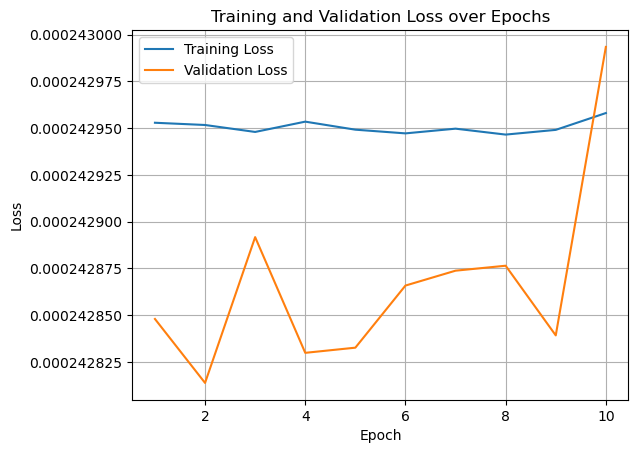

In [22]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, report_freq=300)
    val_loss = evaluate(model, val_loader, criterion, device)

    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.8f}")

    # Save losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Step the scheduler
    scheduler.step(val_loss)

# Plot the losses
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

In [23]:
# Save the model weights at the end of training
save_model(model, save_path)
print(f"Saved model weights to {save_path}")

Saved model weights to ./model_weights.pth


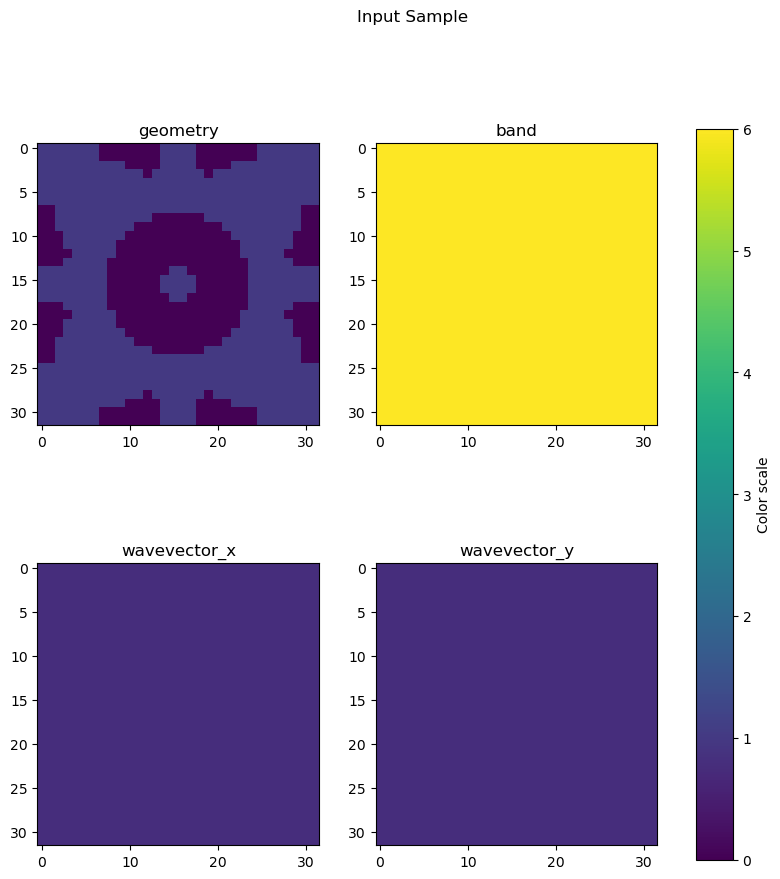

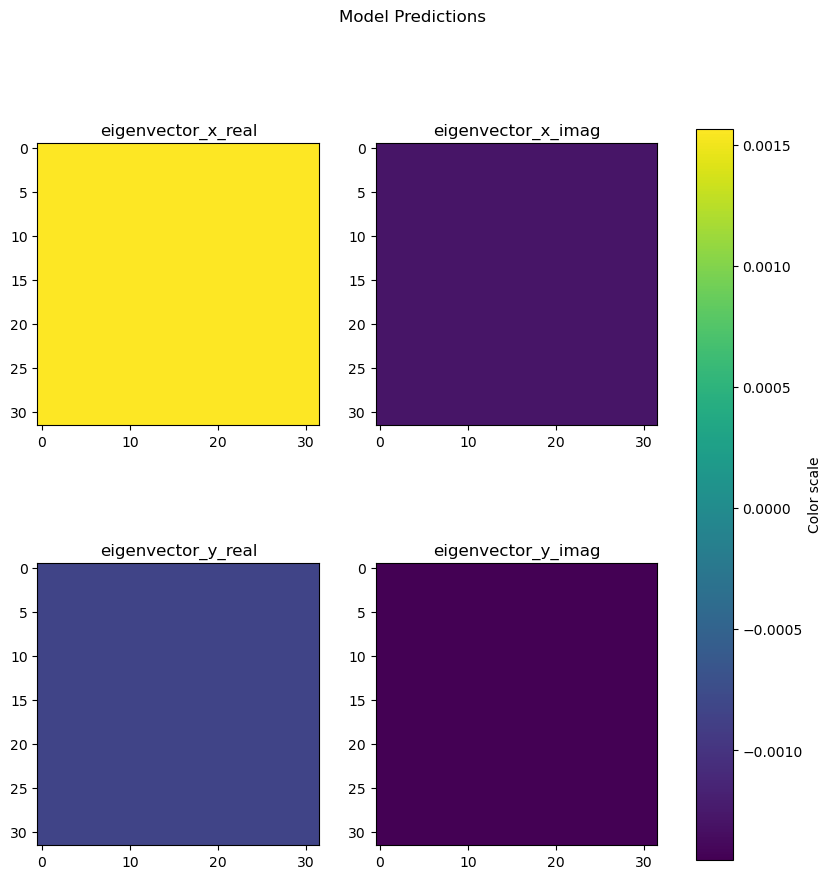

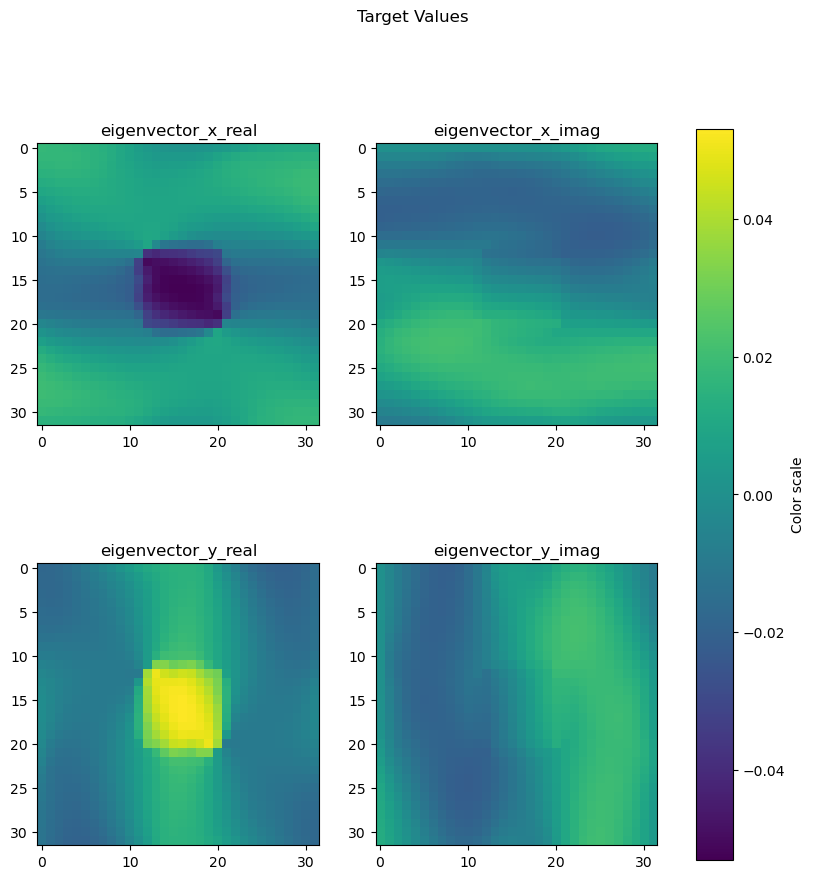

In [24]:
def plot_sample(data, title, labels, shared_colorbar=False):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    if shared_colorbar:
        # Compute global min and max for the shared colorbar
        vmin = np.min(data.cpu().numpy())
        vmax = np.max(data.cpu().numpy())

    for ax, (idx, label) in zip(axes.flatten(), labels):
        im = ax.imshow(data[idx, :, :].cpu(), cmap='viridis', vmin=vmin if shared_colorbar else None, vmax=vmax if shared_colorbar else None)
        ax.set_title(label)
        if not shared_colorbar:
            fig.colorbar(im, ax=ax)

    if shared_colorbar:
        # Add a single colorbar to the right of the plot
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
        cbar.ax.set_ylabel('Color scale')

    plt.suptitle(title)
    plt.show()

def plot_predictions_and_targets(inputs, outputs, targets):
    input_labels = [(0, 'geometry'), (3, 'band'), (1, 'wavevector_x'), (2, 'wavevector_y')]
    plot_sample(inputs, "Input Sample", input_labels, shared_colorbar=True)

    prediction_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(outputs, "Model Predictions", prediction_labels, shared_colorbar=True)

    target_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(targets, "Target Values", target_labels, shared_colorbar=True)

# Get a batch from the validation loader
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

# Get a single sample from the batch
input_sample = inputs[0]
target_sample = targets[0]

# Run the model to get predictions
model.eval()
with torch.no_grad():
    output_sample = model(input_sample.unsqueeze(0)).squeeze(0)

# Plot the inputs, predictions, and targets
plot_predictions_and_targets(input_sample, output_sample, target_sample)
